In [1]:
import cv2
import os
import xml.etree.ElementTree as ET
import glob
import shutil
import random
from PIL import Image
import numpy as np
import ast

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.utils import shuffle


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import tensorflow as tf


2025-05-18 04:14:47.452856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747541687.635025      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747541687.686453      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from functools import partial

from tensorflow.data import Dataset
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, losses, models, optimizers, utils

In [5]:
# Link data cho0-c COLAB
# ZebraDir = '/content/drive/MyDrive/UIT/ComputerVision/ZebraCrossing'
# NonZebraDir = '/content/drive/MyDrive/UIT/ComputerVision/NonZebraCrossing'

# output_dir = '/content/image'
# splits = ['train', 'test', 'valid']

In [6]:
#Link data cho KAGGLE
datav1 = ['/kaggle/input/crossing-data/ComputerVision/ZebraCrossing',
          '/kaggle/input/crossing-data/ComputerVision/NonZebraCrossing']
datav2 = ['/kaggle/input/crossing-data-v3/ZebraCrossingV2',
         '/kaggle/input/crossing-data-v3/NonZebraCrossingV2']

ZebraDir = datav2[0]
NonZebraDir = datav2[1]

output_dir = '/kaggle/working/content/image'
splits = ['train', 'test', 'valid']

In [7]:

for split in splits:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# Chuyển từ VOC sang YOLO format.
def parse_annotation(xml_file, img_w, img_h):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    obj = root.find('object')
    bbox = obj.find('bndbox')

    xmin = float(bbox.find('xmin').text)
    ymin = float(bbox.find('ymin').text)
    xmax = float(bbox.find('xmax').text)
    ymax = float(bbox.find('ymax').text)

    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return [x_center, y_center, width, height]

# Hàm xử lí ảnh và tạo file txt gồm path tới img và label, bndbox
def process_split(src_dir, label, split, output_txt):
    split_dir = os.path.join(src_dir, split)
    dst_dir = os.path.join(output_dir, split)

    with open(output_txt, 'a') as f:
        for file in os.listdir(split_dir):
            if not file.endswith('.jpg'):
                continue
            base = file[:-4]
            img_path = os.path.join(split_dir, file)
            xml_path = os.path.join(split_dir, base + '.xml')

            dst_path = os.path.join(dst_dir, file)
            shutil.copy(img_path, dst_path)

            with Image.open(img_path) as im:
                img_w, img_h = im.size
            
            if label == 1:
                const_label = 1
            else:
                const_label = 0
            if os.path.exists(xml_path):
                bbox = parse_annotation(xml_path, img_w, img_h)
            else:
                bbox = [0.0, 0.0, 0.0, 0.0]

            vector = [const_label] + bbox
            f.write(f"{dst_path} " + " ".join([f"{v:.6f}" for v in vector]) + "\n")

label_txt_colab = "/content/image/"
label_txt_kaggle = "/kaggle/working/content/image/"

# Xử lý ZebraCrossing (label=1)
for split in splits:
    process_split(ZebraDir, label=1, split=split, output_txt=f'{label_txt_kaggle}{split}_labels.txt')

# Xử lý NonZebraCrossing (label=0, no XML)
for split in splits:
    process_split(NonZebraDir, label=0, split=split, output_txt=f'{label_txt_kaggle}{split}_labels.txt')

print("Đã chuẩn bị xong dữ liệu")


Đã chuẩn bị xong dữ liệu


In [8]:
import os

train_dir = '/kaggle/working/content/image/train'
valid_dir = '/kaggle/working/content/image/valid'
test_dir = '/kaggle/working/content/image/test'

def check_length(path):
  if not os.path.exists(path):
      print("Thư mục không tồn tại.")
  else:
      files = os.listdir(path)
      if not files:
          print("Thư mục tồn tại nhưng trống.")
      else:
          print(f"Các file trong thư mục {path[-5:]}:")
          print(len(files))
check_length(train_dir)
check_length(valid_dir)
check_length(test_dir)


Các file trong thư mục train:
1368
Các file trong thư mục valid:
429
Các file trong thư mục /test:
234


In [9]:
# TIền xử lí cho CNN
def load_dataset_from_txt_for_cnn(folder_path, num_classes, image_size=(128, 128)):
    images = []
    labels = []

    with open(folder_path, 'r') as f:
      for line in f:
        parts = line.strip().split()
        image_path = parts[0]
        class_id = int(float(parts[1]))  # 0 or 1
        bbox = list(map(float, parts[2:]))

        img = cv2.imread(image_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        img = img / 255.0

        label = [class_id] + bbox

        images.append(img)
        labels.append(label)

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)


In [10]:
num_classes = 2
image_size = (128, 128)

label_path_colab = "/content/image/"
label_path_kaggle = "/kaggle/working/content/image/"

X_train, y_train = load_dataset_from_txt_for_cnn(f"{label_path_kaggle}train_labels.txt", num_classes, image_size)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

X_val, y_val = load_dataset_from_txt_for_cnn(f"{label_path_kaggle}test_labels.txt", num_classes, image_size)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

X_test, y_test = load_dataset_from_txt_for_cnn(f"{label_path_kaggle}valid_labels.txt", num_classes, image_size)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

y_train_class = y_train[:, 0:1]
y_train_bbox = y_train[:, 1:5]

y_val_class = y_val[:, 0:1]
y_val_bbox = y_val[:, 1:5]


In [11]:
print(f"Shape of X, y train: {X_train.shape}, {y_train.shape}")
print(f"Shape of X, y validation: {X_val.shape}, {y_val.shape}")
print(f"Shape of X, y test: {X_test.shape}, {y_test.shape}")

Shape of X, y train: (1368, 128, 128, 3), (1368, 5)
Shape of X, y validation: (234, 128, 128, 3), (234, 5)
Shape of X, y test: (429, 128, 128, 3), (429, 5)


In [12]:
# Hàm khởi tạo model
def localization_model(IMG_SHAPE):
    inputs = Input(shape=IMG_SHAPE)
    weight_colab = 'imagenet'
    weight_kaggle = '/kaggle/input/weight/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    
    x = ResNet50(include_top=False, weights=None, input_shape=IMG_SHAPE)(inputs)
    x = layers.Conv2D(1024, 3, strides=2, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)

    class_output = layers.Dense(1, activation='sigmoid', name='class_output')(x)
    bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

    model = models.Model(inputs=inputs, outputs=[class_output, bbox_output])
    return model

In [13]:
# Hàm tính IOU cho bounding box
def cal_IoU(b1, b2):
    zero = tf.convert_to_tensor(0., b1.dtype)
    # 2, 3, 4, 4
    b1_xc, b1_yc, b1_w, b1_h = tf.unstack(b1, 4, axis=-1)
    # 6, 2, 8, 4
    b2_xc, b2_yc, b2_w, b2_h = tf.unstack(b2, 4, axis=-1)
    # 0, 1, 4, 5
    b1_x1, b1_y1, b1_x2, b1_y2 = b1_xc - b1_w / 2, b1_yc - b1_h / 2, b1_xc + b1_w / 2, b1_yc + b1_h / 2
    # 2, 0, 10, 4
    b2_x1, b2_y1, b2_x2, b2_y2 = b2_xc - b2_w / 2, b2_yc - b2_h / 2, b2_xc + b2_w / 2, b2_yc + b2_h / 2
    # Union area
    # 16
    b1_area = b1_w * b1_h
    # 32
    b2_area = b2_w * b2_h
    # Intersect area
    # 2
    x1_inter = tf.maximum(b1_x1, b2_x1)
    # 1
    y1_inter = tf.maximum(b1_y1, b2_y1)
    # 4
    x2_inter = tf.minimum(b1_x2, b2_x2)
    # 4
    y2_inter = tf.minimum(b1_y2, b2_y2)
    # 2
    w_inter = tf.maximum(zero, x2_inter - x1_inter)
    # 3
    h_inter = tf.maximum(zero, y2_inter - y1_inter)
    # 6 = 3 * 2
    intersect_area = w_inter * h_inter
    # 32 + 16 - 6 = 42
    union_area = b1_area + b2_area - intersect_area
    # 0.1429
    iou = tf.math.divide_no_nan(intersect_area, union_area)
    return iou

def calculate_iou(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, y_pred.dtype)

    ious = cal_IoU(y_pred, y_true)
    mask = tf.math.greater(ious, 0.01)  # tạo mask boolean
    filtered_iou = tf.boolean_mask(ious, mask)

    return tf.reduce_mean(filtered_iou)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Gọi khởi tạo model
model = localization_model(X_train.shape[1:])

# Callback giảm lr khi huấn luyện
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Compile model
model.compile(
    optimizer='adam',
    loss={
        'class_output': 'binary_crossentropy',
        'bbox_output': 'mean_squared_error'
    },
    loss_weights={
        'class_output': 1.0,
        'bbox_output': 10.0
    },
    metrics={
        'class_output': 'accuracy',
        'bbox_output': calculate_iou
    }
)
model.summary()

I0000 00:00:1747541737.819655      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747541737.820283      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 4, 4, 2048)     │     23,587,712 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1, 1, 1024)     │     18,875,392 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1024)           │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        524,800 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_output (Dense)      │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox_output (Dense)       │ (None, 4)              │          2,052 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 42,990,469 (164.00 MB)

 Trainable params: 42,937,349 (163.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
# Fit model
history = model.fit(
    x=X_train,
    y={'class_output': y_train_class, 'bbox_output': y_train_bbox},
    validation_data=(X_val, {'class_output': y_val_class, 'bbox_output': y_val_bbox}),
    batch_size=32,
    epochs=100,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1747541788.906126      63 service.cc:148] XLA service 0x7af3840afb00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747541788.906605      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747541788.906623      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747541793.982991      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747541812.720785      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 109s 869ms/step - bbox_output_calculate_iou: nan - bbox_output_loss: 0.2081 - class_output_accuracy: 0.5745 - class_output_loss: 7.0307 - loss: 9.1126 - val_bbox_output_calculate_iou: 0.2493 - val_bbox_output_loss: 0.0964 - val_class_output_accuracy: 0.7735 - val_class_output_loss: 0.6655 - val_loss: 1.6361 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - bbox_output_calculate_iou: 0.1577 - bbox_output_loss: 0.0982 - class_output_accuracy: 0.6706 - class_output_loss: 0.6200 - loss: 1.6025 - val_bbox_output_calculate_iou: 0.2336 - val_bbox_output_loss: 0.0997 - val_class_output_accuracy: 0.7735 - val_class_output_loss: 0.6526 - val_loss: 1.6527 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - bbox_output_calculate_iou: 0.2558 - bbox_output_loss: 0.0662 - class_output_accuracy: 0.8091 - class_output_loss: 0.3863 - loss: 1.0482 - val_bbox_output_calculate_iou: 0.1721 - val_bbox_output_loss: 0.0978 - val

In [16]:
print(history.history.keys())


dict_keys(['bbox_output_calculate_iou', 'bbox_output_loss', 'class_output_accuracy', 'class_output_loss', 'loss', 'val_bbox_output_calculate_iou', 'val_bbox_output_loss', 'val_class_output_accuracy', 'val_class_output_loss', 'val_loss', 'learning_rate'])


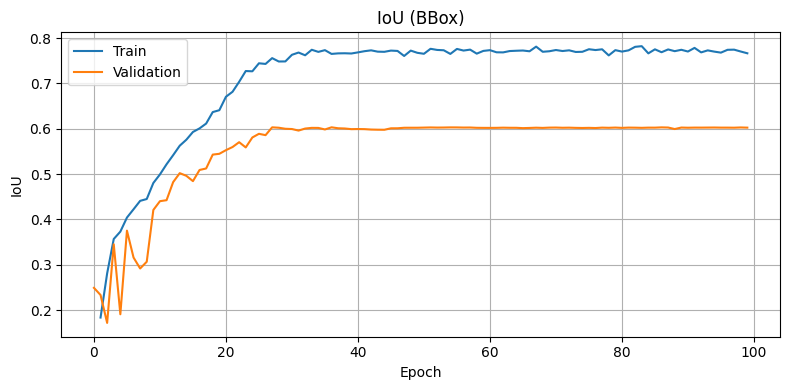

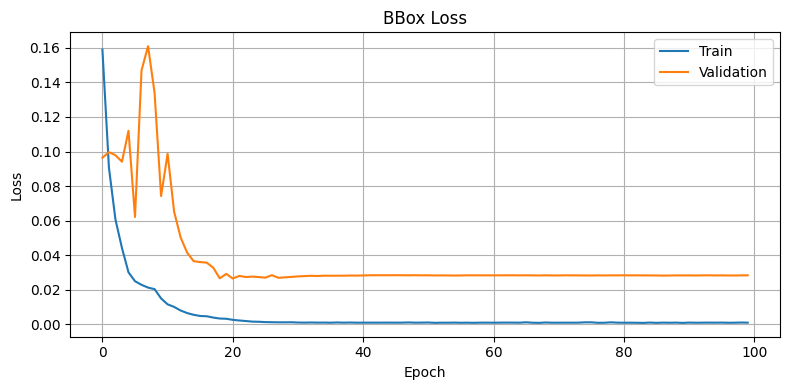

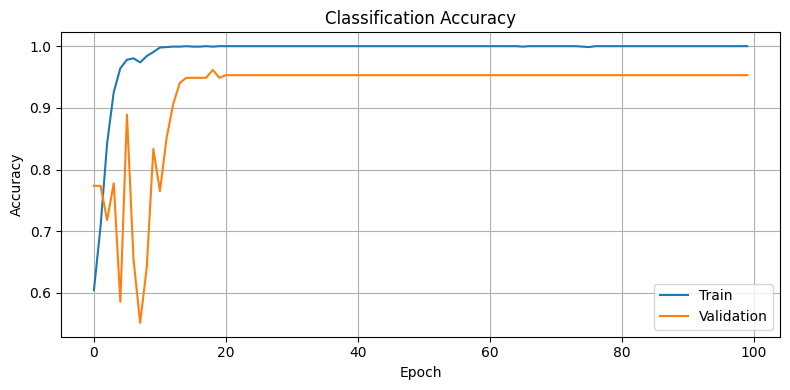

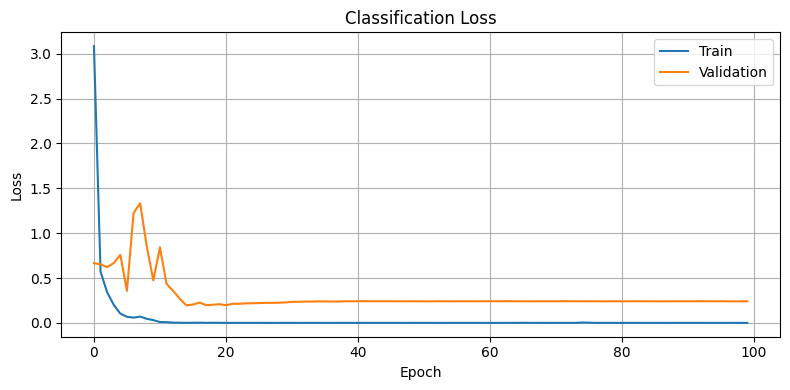

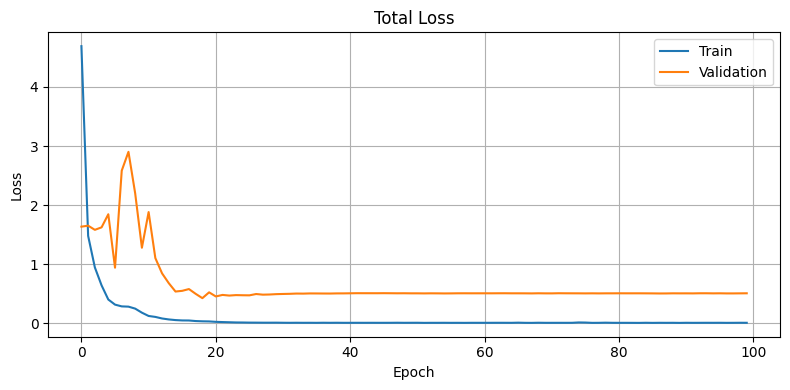

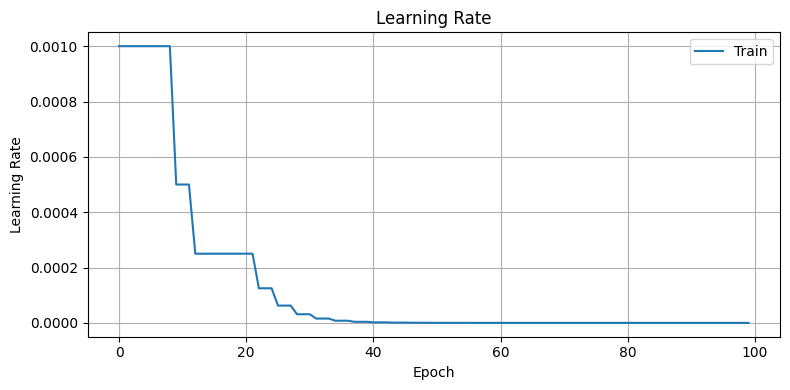

In [17]:
import matplotlib.pyplot as plt

# Plot các metric
def plot_metric(history, metric, val_metric=None, title="", ylabel=""):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric], label='Train')
    if val_metric and val_metric in history.history:
        plt.plot(history.history[val_metric], label='Validation')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Vẽ các biểu đồ
plot_metric(history, "bbox_output_calculate_iou", "val_bbox_output_calculate_iou", "IoU (BBox)", "IoU")
plot_metric(history, "bbox_output_loss", "val_bbox_output_loss", "BBox Loss", "Loss")
plot_metric(history, "class_output_accuracy", "val_class_output_accuracy", "Classification Accuracy", "Accuracy")
plot_metric(history, "class_output_loss", "val_class_output_loss", "Classification Loss", "Loss")
plot_metric(history, "loss", "val_loss", "Total Loss", "Loss")

# Nếu bạn dùng learning rate scheduler
if "lr" in history.history:
    plot_metric(history, "lr", title="Learning Rate", ylabel="Learning Rate")
elif "learning_rate" in history.history:
    plot_metric(history, "learning_rate", title="Learning Rate", ylabel="Learning Rate")


In [18]:
# Dự đoán và kết quả
preds = model.predict(X_test, verbose=0)
pred_class = preds[0] 
pred_class_bin = (pred_class > 0.5).astype(float)
pred_bbox = preds[1]  

y_true_class = y_test[:, 0:1]
y_true_bbox = y_test[:, 1:5]

print("Classification report:")
print(classification_report(y_true_class, pred_class_bin))

ious_arr = []

for i in range(len(y_true_bbox)):
    iou = cal_IoU(tf.expand_dims(y_true_bbox[i], 0), tf.expand_dims(pred_bbox[i], 0))
    ious_arr.append(iou.numpy()[0])
    # print(f"Sample {i}: IoU = {iou.numpy()[0]:.4f}")
iou_mean = sum(ious_arr) / len(ious_arr)
print("IOU Mean : ", iou_mean)

Classification report:
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86        65
         1.0       0.98      0.97      0.97       364

    accuracy                           0.96       429
   macro avg       0.90      0.93      0.92       429
weighted avg       0.96      0.96      0.96       429

IOU Mean :  0.5031899779813586


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def draw_bbox(ax, bbox, color='r', label=None):
    """
    Draw bbox given [xc, yc, w, h] format (in pixels).
    """
    xc, yc, bw, bh = bbox
    x1 = xc - bw / 2
    y1 = yc - bh / 2
    rect = plt.Rectangle((x1, y1), bw, bh, linewidth=2, edgecolor=color, facecolor='none', label=label)
    ax.add_patch(rect)

def evaluate_and_visualize(model, X, y_true, class_names=None, num_samples=5):

    preds = model.predict(X, verbose=0)
    pred_class = preds[0] 
    pred_bbox = preds[1]  

    y_true_class = y_true[:, 0:1]
    y_true_bbox = y_true[:, 1:5]

    for i in range(num_samples):
        img = X[i]
        true_cls = int(y_true_class[i][0])
        pred_cls_val = pred_class[i][0]
        pred_cls_bin = int(pred_cls_val > 0.5)

        h, w = img.shape[:2]
        true_bbox = y_true_bbox[i] * [w, h, w, h]
        pred_bbox_scaled = pred_bbox[i] * [w, h, w, h]

        fig, ax = plt.subplots()
        ax.imshow(img)
        ax.set_title(f"GT class: {true_cls} | Pred class: {pred_cls_bin:.2f}")

        draw_bbox(ax, true_bbox, color='g', label='Ground Truth')

        draw_bbox(ax, pred_bbox_scaled, color='r', label='Prediction')

        plt.legend()
        plt.axis('off')
        plt.show()


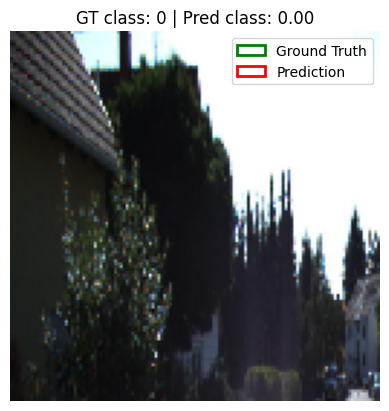

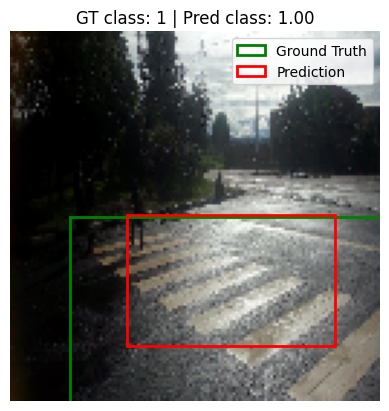

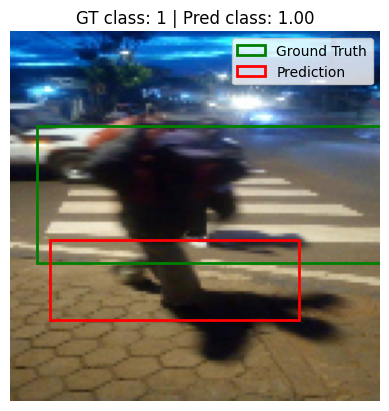

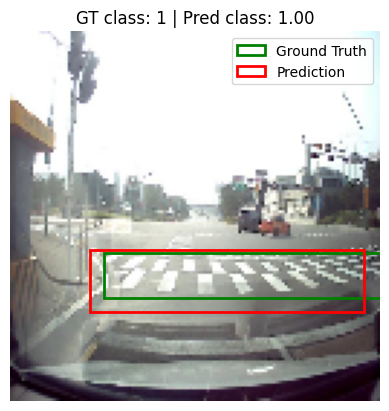

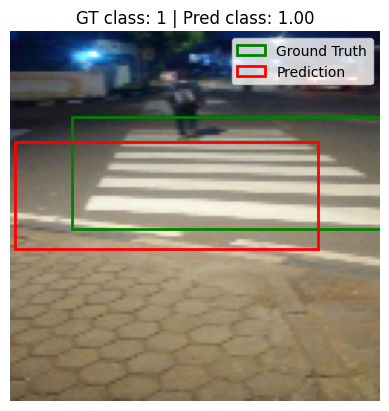

In [20]:
evaluate_and_visualize(model, X_test, y_test, num_samples=5)


In [21]:
filepath = '/kaggle/working/my_model.h5'

tf.keras.models.save_model(model, filepath, overwrite=True)